# 0-Application walk thourgh

In this notebook, we introduce the basics of PyLipID via a walk-through application. We keep the details to minimum and invite users to refer to other specific notebooks in which you can find more details, exercise and theory. 

In this tutorial, we show the PyLipID workflow of checking the lipid interactions with a Class A GPCR, Adenosine A2a receptor from coarse-grained simulations with a complex membrane bilayer that contains 7 lipid species. 

<img src="statics/A2aR_system_overview.png" />

The simulation ensemble reported in the original paper contained 10 repeats, but here we took 2 of the repeats for demonstration and saved in two directories ``run1`` and ``run2``, both of which contains a simulation trajectory ``protein_lipids.xtc`` and a corresponding topology coordinate ``protein_lipids.gro``. The two simulation trajectories have the same topology but different initial configurations. The trajectories were saved with a 20 ns timestep. The trajectories are available for download at [PyLipID Github](https://github.com/wlsong/PyLipID/tree/master/docs/tutorials/traj_data).

In this tutorial, we will first check cholesterol interactions with receptor residues and then interactions with binding sites. We will also illustrate some of the plotting funtions and ways to save the interaction data in various formats that assist different analysis. 

For those of you who are impatient, PyLipID documentation website has provided a **no-brainer script** that runs all PyLipID analysis in one run. The script can be downloaded [here](https://pylipid.readthedocs.io/en/master/demo.html).

In [1]:
%matplotlib inline
import pylipid
from pylipid.api import LipidInteraction
print(pylipid.__version__) # make sure pylipid version is later than 1.4 

1.4.1


## Load data

We start by initializing the main class `LipidInteraction`. 

Trajectories and topology coordinates of the two repeats were saved in the directory ``../../tests/data``. Thus we first create a `trajfile_list` and `topfile_list`. Then, we load the `trajfile_list` and `topfile_list` to `LipidInteraction` together with a couple of calculation settings, including what cutoffs to use, which lipid to check, which lipid atoms are used to define the interactions and what time unit the generated data use etc. You can also specify which directory the generated data should be saved at. But here we will use the default value, i.e. the current working directory. 

In [2]:
trajfile_list = ["./traj_data/A2a/run1/protein_lipids.xtc", "./traj_data/A2a/run2/protein_lipids.xtc"]
topfile_list = ["./traj_data/A2a/run1/protein_lipids.gro", "./traj_data/A2a/run2/protein_lipids.gro"]
lipid = "CHOL"
cutoffs = [0.475, 0.8] # use of dual-cutoff
nprot = 1  # num. of protein copies in the system. if the simulation system has N copies of receptors, 
           # "nprot=N" will report interactions averaged from the N copies, but "nprot=1"
           # will ask pylipid to report interaction data for each copy.
timeunit = 'us' # micro-second
save_dir = None  # if None, pylipid data will be saved at current working directory. 

# initialize 
li = LipidInteraction(trajfile_list, topfile_list=topfile_list, cutoffs=cutoffs, lipid=lipid, 
                      nprot=nprot, save_dir=save_dir)

## Interaction with residues

PyLipID provides functions to calculate the durations, occupancy (percentage of frames in which lipids formed contacts) and lipid count (the average number of surrounding lipids) of lipid interactions with protein residues. In addition, PyLipID can calculate interaction residence time, which is calculated from 1/*k<sub>off<sub>*. The function `collect_residue_contacts()` is required before any of the calculation of interactions with residues. This function will create a index of contacting lipids for each residue at each frame. 

In [3]:
li.collect_residue_contacts()

COLLECT INTERACTIONS FROM TRAJECTORIES: 100%|██████████| 2/2 [01:09<00:00, 34.56s/it]


After this calculation, a pandas.DataFrame is created as an attribute, named `dataset`, of the main class, which is accessible through `li.dataset`. It currently contains only two columns, `Residue` and `Residue ID`, but will be updated each time after a calculation is carried out to the class object `LipidInteraction`, i.e. what `li` refers to here.  

In [4]:
print(li.dataset)

    Residue  Residue ID
0      1ILE           0
1      2MET           1
2      3GLY           2
3      4SER           3
4      5SER           4
..      ...         ...
297  298ARG         297
298  299LYS         298
299  300ILE         299
300  301ILE         300
301  302ARG         301

[302 rows x 2 columns]


### Durations, occupancy and lipid count

After `collect_residue_contacts()`, we can calculate the lipid interactions in a couple of metrics, using different functions. Each function has a parameter of `residue_id` which allows for calculation of specified residues via residue ID. Calculation will run for all residues if `residue_id` is set to the default value of `None`. Let's check the interaction durations for all residues:

In [5]:
durations = li.compute_residue_duration()

The returned `durations` is a list with a length of the number of residues. The n-th list is the durations of lipid interactions with the n-th residue from the trajectories. For example, let's check the durations of the first residue. It shows a list of two list, corresponding to durations from the two trajectories. 

In [6]:
print(len(li.residue_list), len(li.trajfile_list))
print(len(durations), len(durations[0]))
print(durations[0])

302 2
302 2
[[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06, 0.08, 0.1, 0.12, 0.16], [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06, 0.08, 0.1, 0.12, 0.16]]


Alternatively, if we are only interested in checking the interactions with first residue, we can just do the calculation for this residue:

In [7]:
durations_of_first_residue = li.compute_residue_duration(residue_id=0)
print(durations_of_first_residue)

[[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06, 0.08, 0.1, 0.12, 0.16], [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06, 0.08, 0.1, 0.12, 0.16]]


Similary, we can check the occupancy and lipid count as follow, the returned data has the same structure as `compute_residue_duration()`

In [8]:
occupancies = li.compute_residue_occupancy()
lipidcounts = li.compute_residue_lipidcount()
print(len(occupancies), len(occupancies[0]))
print(len(lipidcounts), len(lipidcounts[0]))

302 2
302 2


After each of the above calculation, the pandas.DataFrame that is stored as `dataset` of the main class, is updated to include the average values for each residue. We can have a look at the `dataset` by using `head()` to see the columns have expanded to include "Duration", "Occupancy", "Lipid Count":

In [9]:
li.dataset.head(10) # show 10 lines

,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std
0,1ILE,0,0.048421,0.039104,9.561753,0.0,1.000000,0.0
1,2MET,1,0.033333,0.014907,2.788845,0.0,1.000000,0.0
2,3GLY,2,0.040000,0.000000,0.398406,0.0,1.000000,0.0
3,4SER,3,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,5SER,4,0.102857,0.229765,10.756972,0.0,1.000000,0.0
5,6VAL,5,0.064615,0.065939,12.749004,0.0,1.000000,0.0
6,7TYR,6,0.113571,0.153162,37.051793,0.0,1.043011,0.0
7,8ILE,7,0.128333,0.187520,8.366534,0.0,1.000000,0.0
8,9THR,8,0.093333,0.144026,25.099602,0.0,1.031746,0.0
9,10VAL,9,0.121379,0.155180,19.123506,0.0,1.062500,0.0


In [10]:
print(li.dataset["Duration"])

0      0.048421
1      0.033333
2      0.040000
3      0.000000
4      0.102857
         ...   
297    0.051429
298    0.020000
299    0.096000
300    0.086316
301    0.037143
Name: Duration, Length: 302, dtype: float64


### Residence time and *k<sub>off<sub>*
   

Residence time provides useful insights into the dynamical behavior of the bound lipids, which due to their interaction with the protein, is no longer diffusive. Indeed, we often see both prolonged interactions and quick diffusive contacts of lipids at the protein surface. PyLipID therefore uses bi-exponentials for residence time calculation to account for the long and short decays of lipid relaxation. Residence time is calculated as 1 over *k<sub>off<sub>*, which is calculated from a normalized survival function using the durations. `plot_data` parameter allows for plotting of the *k<sub>off<sub>* data, which provides a more visually straight-forward way to check lipid interactions and understand the data.

In [11]:
koffs, res_times = li.compute_residue_koff(plot_data=True, fig_close=True) 
# fig_close=True will close all the figures. As it can generate substantial amount of figures 
# (one for each residue), leaving all the figures open can consume considerable amount of memory. 

# li.compute_residue_koff(residue_id=[10,15,25,35])
# li.compute_residue_koff(residue_id=10)

CALCULATE KOFF FOR RESIDUES: 100%|██████████| 302/302 [06:08<00:00,  1.22s/it]


The koff figure looks like this:

<img src="statics/koff_figure.png" />

The left panel plots the interactions durations in the sorted order and the right panel plots the normalised survival rates of these interactions (the purple doted line) and the bi-exponential curve fitted to the survival rates (red broken line). To check the sampling quality, the interaction durations are bootstrapped and the fitted curve of the bootstraped interaction durations are plotted in gray lines. Insufficient sampling of interactions would give large deviation to the bootstrapped koffs. 

Again, the `dataset` is updated to include information calculated from koff calculation. Added columns include the average value of each residue of "Residence Time", "Koff", "R Squared", "Residence Time Bootstrap avg", and "R Sqaured Bootstrap". "R Sqaured" is the r_sqaured values of the curve fitting to the normarlised survival function. It indicates the quality of the curve fitting, hence indicates the reliability of the calculated koff and residence time. "Residence Time Bootstrap avg" and "R Squared Bootstrap avg" are the averaged residence time and r_squared from bootstrapping respectively. 

In [12]:
li.dataset.head(10)

,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std,Koff,Residence Time,R Squared,Koff Bootstrap avg,R Squared Bootstrap avg
0,1ILE,0,0.048421,0.039104,9.561753,0.0,1.000000,0.0,7.253660,0.137861,0.999110,14.681331,0.997872
1,2MET,1,0.033333,0.014907,2.788845,0.0,1.000000,0.0,33.012569,0.030291,0.998121,42.320035,0.996846
2,3GLY,2,0.040000,0.000000,0.398406,0.0,1.000000,0.0,29.872911,0.033475,0.975950,29.872911,0.975950
3,4SER,3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,5SER,4,0.102857,0.229765,10.756972,0.0,1.000000,0.0,1.534000,0.651890,0.977403,3.781995,0.975820
5,6VAL,5,0.064615,0.065939,12.749004,0.0,1.000000,0.0,11.007897,0.090844,0.997411,9.873546,0.995620
6,7TYR,6,0.113571,0.153162,37.051793,0.0,1.043011,0.0,2.835653,0.352653,0.995574,4.258164,0.993539
7,8ILE,7,0.128333,0.187520,8.366534,0.0,1.000000,0.0,1.797413,0.556355,0.991546,3.903745,0.991145
8,9THR,8,0.093333,0.144026,25.099602,0.0,1.031746,0.0,2.665541,0.375158,0.986900,3.538163,0.986686
9,10VAL,9,0.121379,0.155180,19.123506,0.0,1.062500,0.0,1.047047,0.955067,0.993749,3.368944,0.994894


## Interaction with binding sites

Before calculation of interactions with binding sites, we need to calculate where the binding sites are. PyLipID calculates the lipid interaction correlations between the protein residues and finds clusters of residues that bind to the same lipid molecule at the same time. This is carried out by computing the community structures of the interaction network of the protein residues. 

In [13]:
node_list, modularity = li.compute_binding_nodes(threshold=4, print_data=False)

# threshold=4 decides that binding sites should contain at least 4 residues. This is particularly 
# helpful when itneraction samplings are not sufficient, in which case false positively correlation 
# is likely to happen among 2 or 3 residues. 
# 
# print_data=True will print the residues for each binding site. It can be quite verbose. 

This function returned two data, first is the `node_list` which is a list of binding site lists. Each binding site list contains the IDs of residues in that binding site. Modularity is the network modularity, which is taken from the Louvain's method of calculating network community structures. Modularity is an indication of the quality of community structures, i.e. binding sites in our cases. The value of `modularity` is between 1 and -1. The closer to 1, the more distinctive the community structures, hence the more trust-worthy the calculated binding sites. Modularity is dependent on the quality of interaction network, which is ultimately dependent on such factors as the sampling of lipid interactions and choice of interaction cutoffs. 

In [14]:
print(node_list)
print()
print(modularity)

[[0, 1, 2, 4, 5, 8, 64], [6, 9, 10, 12, 13, 265, 268, 269, 272, 273, 276, 279], [7, 11, 14, 15, 53, 54, 57, 58, 61], [16, 20, 282, 286, 293, 296, 297, 300], [18, 19, 22, 23, 26, 30, 298, 299, 301], [25, 28, 29, 40, 43, 44, 47, 48, 50, 51, 55, 84, 119, 122, 123, 126], [41, 90, 93, 94, 97, 98, 112, 113, 121, 125, 128, 181, 182, 186], [59, 62, 67, 73], [72, 76, 77, 80, 127, 130, 131, 134, 135, 137, 138], [100, 101, 104, 105, 108, 189, 192, 193], [116, 117, 120, 124], [132, 140, 173, 177], [179, 183, 184, 187, 188, 191, 194, 198, 230, 233, 236, 237, 239, 240, 243, 244], [195, 196, 199, 202, 203], [227, 231, 234, 235, 238, 242, 280, 283, 284, 287, 288], [241, 245, 248, 249, 251, 252, 255, 256, 259, 262, 263, 266, 267, 270]]

0.8300773313665972


Afer this calculation, the `dataset` had a new column `Binding Site ID`, which gives the residues belonging to the same binding site a binding site ID, whereas labels residues that do not belong to any binding site as '-1'. This binding site ID will be an invariable and be accessed through all the binding site calculation. 

In [15]:
li.dataset.head(10)

,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std,Koff,Residence Time,R Squared,Koff Bootstrap avg,R Squared Bootstrap avg,Binding Site ID
0,1ILE,0,0.048421,0.039104,9.561753,0.0,1.000000,0.0,7.253660,0.137861,0.999110,14.681331,0.997872,0
1,2MET,1,0.033333,0.014907,2.788845,0.0,1.000000,0.0,33.012569,0.030291,0.998121,42.320035,0.996846,0
2,3GLY,2,0.040000,0.000000,0.398406,0.0,1.000000,0.0,29.872911,0.033475,0.975950,29.872911,0.975950,0
3,4SER,3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1
4,5SER,4,0.102857,0.229765,10.756972,0.0,1.000000,0.0,1.534000,0.651890,0.977403,3.781995,0.975820,0
5,6VAL,5,0.064615,0.065939,12.749004,0.0,1.000000,0.0,11.007897,0.090844,0.997411,9.873546,0.995620,0
6,7TYR,6,0.113571,0.153162,37.051793,0.0,1.043011,0.0,2.835653,0.352653,0.995574,4.258164,0.993539,1
7,8ILE,7,0.128333,0.187520,8.366534,0.0,1.000000,0.0,1.797413,0.556355,0.991546,3.903745,0.991145,2
8,9THR,8,0.093333,0.144026,25.099602,0.0,1.031746,0.0,2.665541,0.375158,0.986900,3.538163,0.986686,0
9,10VAL,9,0.121379,0.155180,19.123506,0.0,1.062500,0.0,1.047047,0.955067,0.993749,3.368944,0.994894,1


Therefore, to check residues of a binding site and look at their interaction properties, we can use this `Binding Site ID`:

In [16]:
mask = (li.dataset["Binding Site ID"] == 0) # check binding site NO. 0
li.dataset[mask]

,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std,Koff,Residence Time,R Squared,Koff Bootstrap avg,R Squared Bootstrap avg,Binding Site ID
0,1ILE,0,0.048421,0.039104,9.561753,0.0,1.000000,0.0,7.253660,0.137861,0.999110,14.681331,0.997872,0
1,2MET,1,0.033333,0.014907,2.788845,0.0,1.000000,0.0,33.012569,0.030291,0.998121,42.320035,0.996846,0
2,3GLY,2,0.040000,0.000000,0.398406,0.0,1.000000,0.0,29.872911,0.033475,0.975950,29.872911,0.975950,0
4,5SER,4,0.102857,0.229765,10.756972,0.0,1.000000,0.0,1.534000,0.651890,0.977403,3.781995,0.975820,0
5,6VAL,5,0.064615,0.065939,12.749004,0.0,1.000000,0.0,11.007897,0.090844,0.997411,9.873546,0.995620,0
8,9THR,8,0.093333,0.144026,25.099602,0.0,1.031746,0.0,2.665541,0.375158,0.986900,3.538163,0.986686,0
64,65SER,64,0.360000,0.000000,0.398406,0.0,1.000000,0.0,3.454593,0.289470,0.973915,3.454593,0.973915,0


### Durations, occupancy and lipid count

Similar to interaction with residues, interactions with binding sites can also be checked in a couple of metrics. The same syntax is used.

In [17]:
durations = li.compute_site_duration()
occupancies = li.compute_site_occupancy()
lipidcounts = li.compute_site_lipidcount()
print(len(node_list), len(li.trajfile_list))
print(len(durations), len(durations[0]))
print(len(occupancies), len(occupancies[0]))
print(len(lipidcounts), len(lipidcounts[0]))

16 2
16 2
16 2
16 2


Similar to the calculation for residues, the returned list contains calculated values for each binding site from the two trajectories. 

### Residence Time and *k<sub>off<sub>*
    
Similar to that for residue, residence time and *k<sub>off<sub>* can be calculated for binding sites, via the function `compute_site_koff`

In [18]:
koff_BS, res_time_BS = li.compute_site_koff(plot_data=True)

CALCULATE KOFF FOR BINDING SITES: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


The returned values are koff and residence time for each binding site. `plot_data=True` will generate the koff figure shown above for each binding site. Now the `dataset` is expanded to include information for binding site residence time and koff. Residues from the same binding site will record the same binding site interaction data:

In [19]:
li.dataset[li.dataset["Binding Site ID"] == 2]

,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std,Koff,Residence Time,...,R Squared Bootstrap avg,Binding Site ID,Binding Site Duration,Binding Site Occupancy,Binding Site Lipid Count,Binding Site Koff,Binding Site Koff Bootstrap avg,Binding Site Residence Time,Binding Site R Squared,Binding Site R Squared Bootstrap avg
7,8ILE,7,0.128333,0.187520,8.366534,0.0,1.000000,0.0,1.797413,0.556355,...,0.991145,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
11,12LEU,11,0.216364,0.235691,21.513944,0.0,1.055556,0.0,2.641867,0.378520,...,0.996661,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
14,15ALA,14,0.313333,0.180616,1.195219,0.0,1.000000,0.0,2.914877,0.343068,...,0.986410,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
15,16VAL,15,0.125333,0.159911,18.326693,0.0,1.043478,0.0,3.614633,0.276653,...,0.994507,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
53,54GLY,53,0.266667,0.130979,1.593625,0.0,1.000000,0.0,3.722585,0.268631,...,0.985814,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
54,55VAL,54,0.187619,0.182102,20.318725,0.0,1.019608,0.0,3.247807,0.307900,...,0.994736,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
57,58ILE,57,0.289091,0.166103,22.310757,0.0,1.017857,0.0,3.191845,0.313298,...,0.988713,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
58,59PRO,58,0.227500,0.209389,14.342629,0.0,1.055556,0.0,3.140054,0.318466,...,0.996471,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364
61,62ILE,61,0.172727,0.226960,8.764940,0.0,1.000000,0.0,1.742138,0.574007,...,0.991920,2,0.160645,69.920319,69.920319,0.460953,1.947389,2.169418,0.97595,0.995364


`LipidInteraction` also provides a assisting function `binding_site` to show binding site information and show some stats and returns the pandas.DataFrame containing residues of the specified binding site.

In [20]:
df = li.binding_site(binding_site_id=3) # check the binding site No 3
df.head(10)

# Binding site 3
 Binding Site Residence Time:       0.402 us   
 Binding Site Koff:                 2.490  R squared:  0.9984
 Binding Site Duration:             0.084 us   
 Binding Site Occupancy:           36.056 %
 Binding Site Lipid Count:         36.056
 Pos. Charge:        2/8       
 Neg. Charge:        0/8       
 Polar:              0/8       
 Hydrophobic:        4/8       
 Special:            2/8       
 Residue Res ID  Res. Time (us)  Duration (us)   Occupancy (%) Lipid Count  Koff  R Squared 
 297PHE    296       0.286           0.077          10.359        1.000     3.495   0.985   
  21GLY    20        0.171           0.063           3.187        1.000     5.864   0.982   
 301ILE    300       0.108           0.086          11.155        1.000     9.302   0.997   
  17LEU    16        0.051           0.045          13.944        1.029    19.618   0.999   
 298ARG    297       0.045           0.051           3.187        1.000    22.147   0.990   
 283PRO    282       

,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std,Koff,Residence Time,...,R Squared Bootstrap avg,Binding Site ID,Binding Site Duration,Binding Site Occupancy,Binding Site Lipid Count,Binding Site Koff,Binding Site Koff Bootstrap avg,Binding Site Residence Time,Binding Site R Squared,Binding Site R Squared Bootstrap avg
282,283PRO,282,0.020000,0.000000,0.398406,0.0,1.000000,0.0,0.000000,0.000000,...,-0.004016,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
286,287ALA,286,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
293,294ARG,293,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
297,298ARG,297,0.051429,0.014569,3.187251,0.0,1.000000,0.0,22.146628,0.045154,...,0.988172,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
16,17LEU,16,0.045161,0.037663,13.944223,0.0,1.028571,0.0,19.618491,0.050972,...,0.998477,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
300,301ILE,300,0.086316,0.065551,11.155378,0.0,1.000000,0.0,9.301757,0.107507,...,0.995289,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
20,21GLY,20,0.063333,0.088255,3.187251,0.0,1.000000,0.0,5.864159,0.170527,...,0.981116,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904
296,297PHE,296,0.077500,0.101704,10.358566,0.0,1.000000,0.0,3.495447,0.286086,...,0.988683,3,0.08427,36.055777,36.055777,2.489836,8.611201,0.401633,0.0,0.998904


## Analyze bound poses

Once the binding sites are defined, we can proceed to analyze bound poses, e.g. check the most representative bound poses for binding sites and check bound pose clusters for binding sites etc. 

ANALYZE BOUND POSES: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


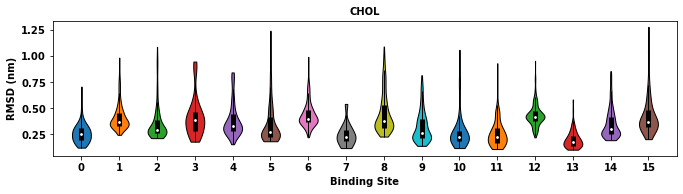

In [21]:
pose_pool, pose_rmsd = li.analyze_bound_poses(binding_site_id=None, pose_format="pdb",
                                             n_poses=3, n_clusters='auto') # None means analysis for all residues

`analyze_bound_poses()` will rate the bound poses for each binding site based on probability density calculated from the simulation trajectories and write out a couple of top rated poses (controled by `n_poses`). It will also cluster the bound poses for each binding site, for which the number of clusters can be determined by a density based cluster `DBSCAN` or provided by users via the parameter `n_clusters`. So for each binding site, it will generate two directories (if `n_clusters` is not `0`), one for top-rated poses (in the directory of 'BSid{num}\_rank') and one for all the clustered poses (in the directory of 'BSid{num}\_clusters'). All these directories are then put under the "Bound_Poses_{lipid}" directory if the parameter `save_dir` is None, i.e. not given. An overview of the directories organisation is shown below:

<img src="statics/directory_overview.gif" />

The written poses store the lipid pose and the recetpor conformation that this pose was bound to. By default, the pose files are saved in the Gromacs 'gro' format but can be changed to, e.g. 'pdb' format by the parameter `pose_format`. For the top-ranked poses, the pose named 'top1' is the one with highest scores, i.e. the most representative bound pose from the simulations; and 'top2' is the second, and so on. For coarse-grained simulations, these top-ranked poses can be quite similar to each other due to the smoothened potentials. These poses can be checked by such molecular visualization softwares as VMD and PyMol etc. Below shows the top rated bound cholesterol pose at binding site No 3 of A2a. This cholesterol binding site have been seen in many of the Class A GPCR x-ray structures:

<img src="statics/BSid3_top1.png" />


The lipid bound poses for each binding site will be returned. The RMSD of bound poses to the binding site average will be returned and plotted in a violin plot. 

<img src="statics/Pose_RMSD_violinplot.png" />

Similar to other analysis functions, `analyze_bound_poses` can also select a couple of binding sites for analysis via `binding_site_id`. 

The returned `pose_pool` is a `dict` object that stores bound poses for binding sites, with the binding site id as the dictionary keys and the bound pose coordinates as the corresponding values. `pose_rmsd` is a pandas.DataFrame that stores RMSD for the bound poses (in unit of nm).

In [22]:
pose_rmsd.head()

,Binding Site 0,Binding Site 1,Binding Site 2,Binding Site 3,Binding Site 4,Binding Site 5,Binding Site 6,Binding Site 7,Binding Site 8,Binding Site 9,Binding Site 10,Binding Site 11,Binding Site 12,Binding Site 13,Binding Site 14,Binding Site 15
0,0.223374,0.286227,0.300190,0.466709,0.761617,0.198151,0.447075,0.535007,0.301005,0.259953,0.173734,0.184561,0.400426,0.114028,0.272330,0.650654
1,0.201861,0.487580,0.458015,0.939967,0.320493,0.218504,0.455287,0.280713,0.333796,0.223549,0.189162,0.171577,0.411913,0.186465,0.651162,1.028023
2,0.256779,0.423737,0.361755,0.407418,0.827482,0.202058,0.279600,0.128544,0.700445,0.606836,0.131934,0.421516,0.432357,0.117859,0.203470,0.512449
3,0.188669,0.613928,0.284363,0.320338,0.819989,0.275927,0.350684,0.260252,0.330722,0.186338,0.214737,0.260642,0.340274,0.266181,0.831994,0.410526
4,0.270946,0.379717,0.290901,0.251954,0.415598,0.221495,0.477152,0.152749,0.399091,0.257155,0.343621,0.126772,0.444449,0.281716,0.281744,0.578883


## Calculate surface area

We can also calculate the surface area for binding site, obtaining the values as a function of time. `print_data=True` generates a timeseries plot and a violinplot.

CALCULATE SURFACE AREA PER TRAJ: 100%|██████████| 2/2 [00:39<00:00, 19.85s/it]


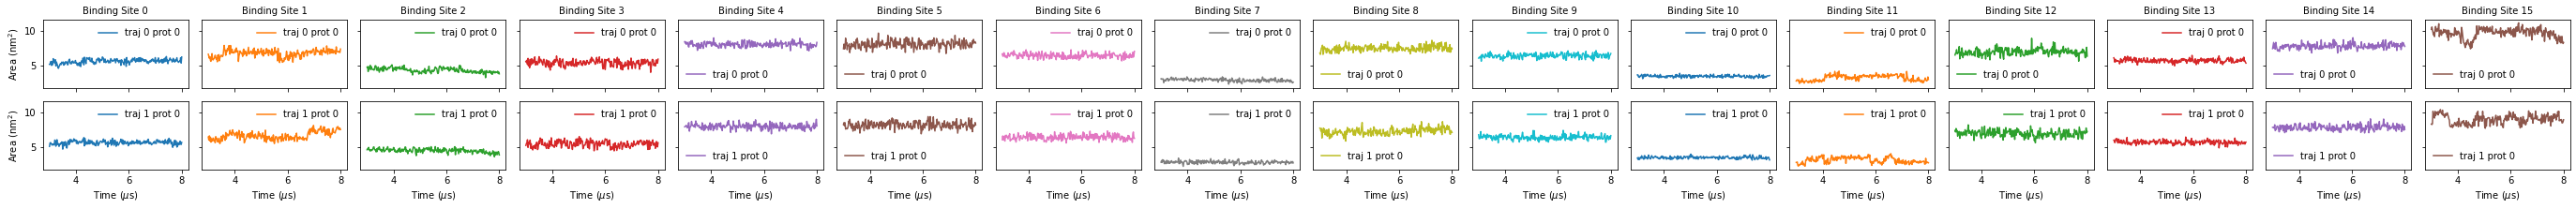

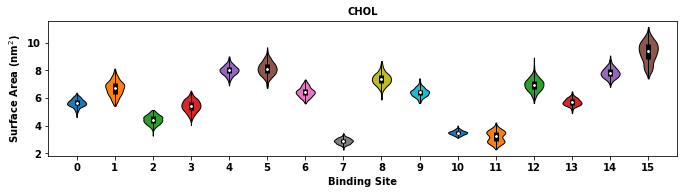

In [23]:
surface_area = li.compute_surface_area(plot_data=True)

The returned `surface_area` is pandas.DataFrame object that stores the time evolution of the surface area for each binding site. The reported values are in the unit of nm^2.

In [24]:
surface_area.head()

Binding Site 0  Binding Site 1  Binding Site 2  Binding Site 3  \
0 0 0        5.180549        6.638932        4.771338        5.615480   
    1        5.207631        6.342386        4.854055        5.471372   
    2        5.548610        6.051907        4.155757        5.773362   
    3        5.607398        6.297503        4.840330        5.169632   
    4        5.024073        5.767179        4.491976        6.042726   

       Binding Site 4  Binding Site 5  Binding Site 6  Binding Site 7  \
0 0 0        8.439785        7.430770        6.675558        3.112179   
    1        8.236421        8.092450        6.375057        3.053345   
    2        8.401709        7.381920        6.326932        3.097847   
    3        8.060047        7.563210        6.857869        3.061316   
    4        8.211236        8.938884        6.745952        3.098440   

       Binding Site 8  Binding Site 9  Binding Site 10  Binding Site 11  \
0 0 0        6.802101        6.082333         3.672477         2.797386   
    1        6.605942        6.185533         3.687601         2.938696   
    2        7.134958        6.113369         3.402123         2.984755   
    3        7.546908        6.299103         3.462173         2.878154   
    4        7.549766        6.360433         3.322324         2.768911   

       Binding Site 12  Binding Site 13  Binding Site 14  Binding Site 15  \
0 0 0         6.524115         6.126667         7.443302        10.201455   
    1         6.783461         5.917765         7.889165        10.546230   
    2         6.902515         5.497607         8.331194        10.137549   
    3         7.297023         5.904237         7.505406         9.765058   
    4         6.700088         5.717446         8.112361         9.410940   

       Time  
0 0 0  3.00  
    1  3.02  
    2  3.04  
    3  3.06  
    4  3.08

Similar to other binding site analysis functions, `compute_surface_area` allows for selection of binding site for calculation via `binding_site_id`.


The calculation of surface area needs definition of the radii of atoms in the system. The function uses `mdtraj`'s atom radii and defines the radii of MARTINI 2 beads. New radii definition can be provided via `radii`. 

## Plots and save data

The class object `LipidInteraction` provides a couple of assisting functions to plot and save data. These figures plot various interaction metrics as a function of the protein residue index. These figures help to point out the contact hotspots. 

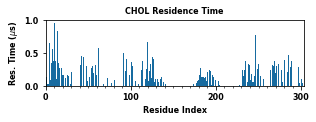

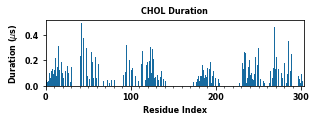

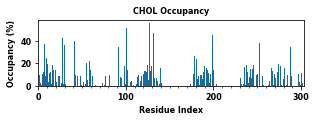

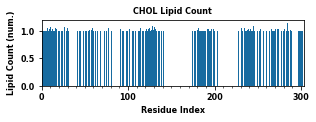

In [25]:
for item in ["Residence Time", "Duration", "Occupancy", "Lipid Count"]:
    li.plot(item=item) # plot values as a function of time

PyLipID also plots interactions in logo figures generated by logomakek. This kind of figure can directly point out the amino acids that make the contacts. It could be helpful to understand the chemical nature of lipid interactions. 

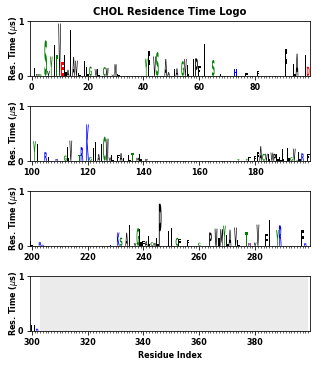

In [26]:
li.plot_logo(item="Residence Time")

As mentioned above, the calculated binding site information can be saved in a text file. The order of the data can be controled by the `sort_residue` parameter:

In [27]:
li.write_site_info(sort_residue="Residence Time") # write binding site information in a txt file

To assist understanding of the interaction from a structural perspective, PyLipID can also save the interaction information in the B factor column of the protein coordinate in the pdb format. The following example will save the 'Residence Time' of each residue in a pdb file "Coordinate_CHOL_Residence_Time.pdf" in the directory of "Coordinate_{lipid}":

In [28]:
li.save_coordinate(item="Residence Time") # write protein coordinate in pdb format with the b factor column
                                          # showing 'Residence Time' values

Creating new director: /Users/lindasong/PyLipID/PyLipID-dev/docs/tutorials/Interaction_CHOL/Coordinate_CHOL


The coordinate file can be viewed in such visualization softwares as VMD and PyMol, and the structure can be coloured based on B factors to obtain the following images:

<img src="statics/surface_hotspots.png" />

Shown above are the A2aR structure in the coarse-grained model. To make the secondary and teriary structure clearer, only the backbone beads were shown whereas the side beads were hidden. A 'white to red' color map was used to show the residence time for each residue in VMD. The interaction hotspots and their locations can be easily analyzed through such a presentation. 